## Purpose of this notebook is to add new stats from baseball savant, to attempt to improve the model

Here is what will be added:

- **Quality of Contact Stats:**  
    - Flare/Burner %  
    - Under %  
    - Topped %  
    - Poor/Weak %
- **Pitches and Location Stats:**
    - In Zone Contact %
    - First Strike %
    
Good resource: https://www.pitcherlist.com/beyond-the-barrel-an-introduction-to-ideal-contact-rate/

Loading in needed packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from IPython.core.display import display, HTML    # make sure Jupyter knows to display it as HTML
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import unicodedata

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10

In [3]:
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

Changing Working directory:

In [4]:
pwd

'/Users/patrickbovard/Documents/GitHub/Metis_Project_2'

In [5]:
cd Webscraping_code

/Users/patrickbovard/Documents/GitHub/Metis_Project_2/Webscraping_code


Now, import the functions I need:

In [9]:
from baseball_savant_code import *
from fangraphs_wrc_code import *

Add in the URL's: 

In [10]:
savant_url = 'https://baseballsavant.mlb.com/leaderboard/custom?year=2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=16&sortDir=desc&min=200&selections=player_age,b_total_pa,b_game,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,iz_contact_percent,pull_percent,straightaway_percent,opposite_percent,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,sprint_speed,&chart=true&x=player_age&y=player_age&r=no&chartType=beeswarm'
fg_url = 'https://www.fangraphs.com/leaders/season-stat-grid?position=B&seasonStart=2015&seasonEnd=2020&stat=wRC%2B&pastMinPt=200&curMinPt=0&mode=normal'

Create dataframes:

In [11]:
savant_df = Savant_DataFrame_Builder(savant_url)

In [13]:
fg_df = wRC_DataFrame_Shifter(fg_url)

In [7]:
savant_df.head()

Player    Year   Age     PA      G  Avg EV (MPH)  \
Rk.                                                                   
1     Astudillo, Willians  2019.0  28.0  204.0   58.0          85.9   
2             Revere, Ben  2015.0  27.0  634.0  152.0          83.1   
3             Holt, Brock  2016.0  28.0  324.0   94.0          86.0   
4          Murphy, Daniel  2015.0  30.0  538.0  130.0          89.9   
5          Iglesias, Jose  2015.0  25.0  454.0  120.0          83.8   

     Avg LA (°)  Barrel%  Solid Contact % Flare/Burner %  ...  \
Rk.                                                       ...   
1          15.4      2.7              5.4           28.0  ...   
2           5.0      0.0              2.1           30.0  ...   
3           6.3      2.5              4.7           28.8  ...   
4          11.9      4.9              6.2           25.3  ...   
5           4.6      0.0              1.3           24.0  ...   

    In Zone Contact % Pull % Straight Away %  Oppo %  First Strike %   GB%  \
Rk.                                                                          
1                96.8   39.2            37.1    23.7            64.7  40.3   
2                96.4   34.3            41.2    24.4            56.6  57.1   
3                96.0   35.2            34.7    30.1            58.6  55.1   
4                95.9   37.3            35.1    27.6            57.2  43.3   
5                95.5   33.0            38.8    28.2            63.4  59.1   

      FB%  LD %  Sprint Speed              Player Link  
Rk.                                                     
1    21.0  29.0          24.2  [/savant-player/553902]  
2    14.6  26.9          28.4  [/savant-player/519184]  
3    14.0  25.8          28.2  [/savant-player/571788]  
4    23.6  25.7          25.7  [/savant-player/502517]  
5    11.6  21.9          28.4  [/savant-player/578428]  

[5 rows x 26 columns]

In [8]:
savant_df.shape

(1893, 26)

## Merge The DF's
*Note: this code is originally from Project_2_Savant notebook, moving here to clean up the workflow.*

In [9]:
fg_df.rename(columns={'Name-Year':'Player_Year_ID'}, inplace=True)

In [10]:
fg_df.head(2)

Player_Year_ID wRC+
0  Michael Lorenzen-2015    0
1  Michael Lorenzen-2016    0

Function to strip accent marks from names so they can all be mapped to the savant data:

In [11]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

In [12]:
player_list = fg_df.Player_Year_ID.to_list()

In [13]:
updated_names = [strip_accents(name).replace('?','e') for name in player_list]

In [14]:
updated_names

['Michael Lorenzen-2015',
 'Michael Lorenzen-2016',
 'Michael Lorenzen-2017',
 'Michael Lorenzen-2018',
 'Michael Lorenzen-2019',
 'Michael Lorenzen-2020',
 'Luis Campusano-2015',
 'Luis Campusano-2016',
 'Luis Campusano-2017',
 'Luis Campusano-2018',
 'Luis Campusano-2019',
 'Luis Campusano-2020',
 'Billy McKinney-2015',
 'Billy McKinney-2016',
 'Billy McKinney-2017',
 'Billy McKinney-2018',
 'Billy McKinney-2019',
 'Billy McKinney-2020',
 'Rafael Marchan-2015',
 'Rafael Marchan-2016',
 'Rafael Marchan-2017',
 'Rafael Marchan-2018',
 'Rafael Marchan-2019',
 'Rafael Marchan-2020',
 'Travis Blankenhorn-2015',
 'Travis Blankenhorn-2016',
 'Travis Blankenhorn-2017',
 'Travis Blankenhorn-2018',
 'Travis Blankenhorn-2019',
 'Travis Blankenhorn-2020',
 'Yolmer Sanchez-2015',
 'Yolmer Sanchez-2016',
 'Yolmer Sanchez-2017',
 'Yolmer Sanchez-2018',
 'Yolmer Sanchez-2019',
 'Yolmer Sanchez-2020',
 'Andrew Stevenson-2015',
 'Andrew Stevenson-2016',
 'Andrew Stevenson-2017',
 'Andrew Stevenson-201

In [15]:
fg_df.Player_Year_ID = updated_names

Back to Baseball Savant:

In [16]:
player_list = savant_df.Player.tolist()

In [17]:
player_list_split = [player.split(', ') for player in player_list]
for player in player_list_split:
    player[0] = player[0].strip()

final_player_list = [(player[1] + ' ' + player[0]) for player in player_list_split]    

In [18]:
print(final_player_list)

['Willians Astudillo', 'Ben Revere', 'Brock Holt', 'Daniel Murphy', 'Jose Iglesias', 'Michael Brantley', 'Jose Iglesias', 'David Fletcher', 'David Fletcher', 'Michael Brantley', 'Eric Sogard', 'Ben Revere', 'JB Shuck', 'Michael Brantley', 'Norichika Aoki', 'David Fletcher', 'Martin Prado', 'Isiah Kiner-Falefa', 'Daniel Murphy', 'Jonathan Lucroy', 'Luis Arraez', 'Eric Sogard', 'Martin Prado', 'Jean Segura', 'Ben Revere', 'Yuli Gurriel', 'Martin Prado', 'Miguel Rojas', 'Joe Panik', 'Eric Sogard', 'Yangervis Solarte', 'Brayan Pena', 'Jose Altuve', 'Joe Panik', 'Joe Panik', 'Melky Cabrera', 'Mookie Betts', 'Sam Fuld', 'Alberto Callaspo', 'Jose Peraza', 'Miguel Rojas', 'Ender Inciarte', 'James Loney', 'Ender Inciarte', 'Denard Span', 'Ian Kinsler', 'Ichiro Suzuki', 'Christian Vazquez', 'DJ LeMahieu', 'Mookie Betts', 'David DeJesus', 'Carlos Ruiz', 'DJ LeMahieu', 'Carlos Ruiz', 'Andrelton Simmons', 'Joe Panik', 'AJ Pollock', 'Erick Aybar', 'Jose Iglesias', 'Kevin Newman', 'Denard Span', 'Nic

In [19]:
year_list = savant_df.Year.tolist()

In [20]:
year_list = [int(year) for year in year_list]
print(year_list)

[2019, 2015, 2016, 2015, 2015, 2015, 2016, 2020, 2018, 2018, 2015, 2016, 2016, 2019, 2015, 2019, 2015, 2018, 2016, 2017, 2019, 2019, 2016, 2018, 2017, 2020, 2019, 2017, 2019, 2017, 2015, 2015, 2015, 2018, 2016, 2017, 2020, 2015, 2015, 2018, 2018, 2016, 2016, 2015, 2015, 2015, 2015, 2018, 2018, 2016, 2015, 2015, 2020, 2016, 2019, 2017, 2015, 2015, 2018, 2019, 2017, 2018, 2019, 2016, 2016, 2017, 2015, 2018, 2016, 2015, 2015, 2016, 2017, 2015, 2019, 2015, 2018, 2019, 2019, 2016, 2016, 2016, 2015, 2019, 2016, 2016, 2017, 2015, 2019, 2016, 2015, 2015, 2018, 2019, 2016, 2016, 2017, 2018, 2019, 2019, 2015, 2018, 2019, 2016, 2017, 2017, 2018, 2019, 2016, 2016, 2015, 2015, 2015, 2015, 2018, 2018, 2016, 2017, 2017, 2017, 2017, 2015, 2018, 2017, 2017, 2020, 2020, 2019, 2019, 2019, 2016, 2016, 2015, 2015, 2015, 2015, 2015, 2019, 2016, 2017, 2017, 2017, 2015, 2015, 2019, 2019, 2019, 2019, 2016, 2017, 2017, 2015, 2015, 2015, 2018, 2018, 2016, 2017, 2015, 2015, 2018, 2018, 2018, 2018, 2019, 2016, 201

In [21]:
player_year_id = []
for i, player in enumerate(final_player_list):
    id_str = player + "-" + str(year_list[i])
    player_year_id.append(id_str)
print(player_year_id)

['Willians Astudillo-2019', 'Ben Revere-2015', 'Brock Holt-2016', 'Daniel Murphy-2015', 'Jose Iglesias-2015', 'Michael Brantley-2015', 'Jose Iglesias-2016', 'David Fletcher-2020', 'David Fletcher-2018', 'Michael Brantley-2018', 'Eric Sogard-2015', 'Ben Revere-2016', 'JB Shuck-2016', 'Michael Brantley-2019', 'Norichika Aoki-2015', 'David Fletcher-2019', 'Martin Prado-2015', 'Isiah Kiner-Falefa-2018', 'Daniel Murphy-2016', 'Jonathan Lucroy-2017', 'Luis Arraez-2019', 'Eric Sogard-2019', 'Martin Prado-2016', 'Jean Segura-2018', 'Ben Revere-2017', 'Yuli Gurriel-2020', 'Martin Prado-2019', 'Miguel Rojas-2017', 'Joe Panik-2019', 'Eric Sogard-2017', 'Yangervis Solarte-2015', 'Brayan Pena-2015', 'Jose Altuve-2015', 'Joe Panik-2018', 'Joe Panik-2016', 'Melky Cabrera-2017', 'Mookie Betts-2020', 'Sam Fuld-2015', 'Alberto Callaspo-2015', 'Jose Peraza-2018', 'Miguel Rojas-2018', 'Ender Inciarte-2016', 'James Loney-2016', 'Ender Inciarte-2015', 'Denard Span-2015', 'Ian Kinsler-2015', 'Ichiro Suzuki-2

In [22]:
savant_df['Player_Year_ID'] = player_year_id

In [23]:
savant_df.sample(15)

Player    Year   Age     PA      G  Avg EV (MPH)  \
Rk.                                                                     
1872          Carter, Chris  2015.0  29.0  460.0  129.0          91.3   
1341   Gurriel Jr., Lourdes  2020.0  27.0  224.0   57.0          90.8   
1207         Valbuena, Luis  2016.0  31.0  342.0   90.0          87.4   
1680       Schoop, Jonathan  2015.0  24.0  321.0   86.0          89.9   
1465          Riley, Austin  2020.0  23.0  206.0   51.0          91.0   
1334     Heredia, Guillermo  2019.0  28.0  231.0   89.0          86.6   
968          Martinez, J.D.  2019.0  32.0  657.0  146.0          91.3   
1020          Pearce, Steve  2015.0  32.0  325.0   92.0          86.9   
1679        Herrmann, Chris  2017.0  30.0  256.0  106.0          89.1   
1111        Bader, Harrison  2019.0  25.0  406.0  128.0          88.4   
644          Johnson, Kelly  2015.0  33.0  335.0  111.0          87.0   
163           Gurriel, Yuli  2018.0  34.0  573.0  136.0          89.3   
1183          Sanchez, Gary  2016.0  24.0  229.0   53.0          92.7   
950          Heyward, Jason  2019.0  30.0  589.0  147.0          88.8   
1173    Cervelli, Francisco  2018.0  32.0  404.0  104.0          88.8   

      Avg LA (°)  Barrel%  Solid Contact % Flare/Burner %  ... Pull %  \
Rk.                                                        ...          
1872        21.2     15.5             10.2           14.3  ...   38.0   
1341        10.5     11.7              3.1           24.7  ...   38.3   
1207        16.1      7.4              6.0           22.7  ...   44.0   
1680        12.8      8.7              5.7           27.1  ...   41.9   
1465        13.6     10.0              5.0           24.3  ...   41.4   
1334        12.9      2.7              4.8           29.3  ...   42.2   
968         12.4     11.8              7.5           29.2  ...   38.2   
1020        19.5      5.3              8.4           19.9  ...   48.2   
1679        10.3      7.5              9.4           20.6  ...   30.0   
1111        15.3      9.9              7.7           19.7  ...   37.3   
644         12.6      8.3              3.0           24.8  ...   38.3   
163         11.5      1.9              5.2           24.1  ...   36.0   
1183         7.9     15.8              5.5           24.0  ...   49.3   
950         11.3      5.7              5.9           25.4  ...   39.4   
1173        16.3      8.3              9.4           23.2  ...   35.4   

     Straight Away % Oppo %  First Strike %   GB%   FB%  LD %  Sprint Speed  \
Rk.                                                                           
1872            38.0   24.1            62.0  30.6  33.5  24.9          26.5   
1341            39.5   22.2            68.8  41.4  16.7  36.4          26.3   
1207            33.8   22.2            56.7  39.4  28.2  24.1          25.6   
1680            32.3   25.8            66.0  43.7  18.8  27.5          26.7   
1465            31.4   27.1            65.0  42.1  20.0  30.7          26.8   
1334            32.7   25.2            64.9  41.5  23.1  26.5          28.2   
968             35.3   26.5            61.6  43.0  25.6  28.5          26.7   
1020            31.0   20.8            57.2  35.0  29.2  23.5          26.8   
1679            46.9   23.1            57.8  45.0  28.8  21.9          27.1   
1111            41.6   21.0            60.8  40.8  26.6  21.9          29.5   
644             38.3   23.5            56.4  44.8  22.2  26.1          27.5   
163             42.4   21.6            63.4  44.9  20.2  25.8          27.6   
1183            35.6   15.1            58.1  49.3  18.5  24.0          26.2   
950             38.7   21.9            54.5  47.3  20.4  25.1          27.4   
1173            38.2   26.4            60.6  39.4  26.0  26.0          25.8   

                  Player Link            Player_Year_ID  
Rk.                                                      
1872  [/savant-player/474892]         Chris Carter-2015  
1341  [/savant-play

Actual merging:

In [24]:
combined_df = savant_df.merge(fg_df, how='left', on='Player_Year_ID')

In [25]:
combined_df

Player    Year   Age     PA      G  Avg EV (MPH)  \
0      Astudillo, Willians  2019.0  28.0  204.0   58.0          85.9   
1              Revere, Ben  2015.0  27.0  634.0  152.0          83.1   
2              Holt, Brock  2016.0  28.0  324.0   94.0          86.0   
3           Murphy, Daniel  2015.0  30.0  538.0  130.0          89.9   
4           Iglesias, Jose  2015.0  25.0  454.0  120.0          83.8   
...                    ...     ...   ...    ...    ...           ...   
1888           Gallo, Joey  2017.0  24.0  532.0  145.0          93.3   
1889             Happ, Ian  2018.0  24.0  462.0  142.0          90.0   
1890         Hiura, Keston  2020.0  24.0  246.0   59.0          87.4   
1891         Broxton, Keon  2019.0  29.0  228.0  100.0          88.1   
1892         Broxton, Keon  2017.0  27.0  463.0  143.0          87.3   

      Avg LA (°)  Barrel%  Solid Contact % Flare/Burner %  ...  \
0           15.4      2.7              5.4           28.0  ...   
1            5.0      0.0              2.1           30.0  ...   
2            6.3      2.5              4.7           28.8  ...   
3           11.9      4.9              6.2           25.3  ...   
4            4.6      0.0              1.3           24.0  ...   
...          ...      ...              ...            ...  ...   
1888        23.0     22.1              8.3           16.6  ...   
1889        14.1     12.2              5.9           26.6  ...   
1890        14.3     14.2              4.5           22.4  ...   
1891        10.3      5.8              7.8           19.4  ...   
1892        10.5     11.6              4.6           24.9  ...   

     Straight Away % Oppo % First Strike %   GB%   FB%  LD % Sprint Speed  \
0               37.1   23.7           64.7  40.3  21.0  29.0         24.2   
1               41.2   24.4           56.6  57.1  14.6  26.9         28.4   
2               34.7   30.1           58.6  55.1  14.0  25.8         28.2   
3               35.1   27.6           57.2  43.3  23.6  25.7         25.7   
4               38.8   28.2           63.4  59.1  11.6  21.9         28.4   
...              ...    ...            ...   ...   ...   ...          ...   
1888            29.2   20.6           57.5  29.2  37.9  22.1         27.8   
1889            36.0   28.8           57.8  40.5  24.8  27.5         27.6   
1890            40.3   23.9           54.1  44.0  21.6  26.9         27.0   
1891            38.8   26.2           69.7  51.5  22.3  19.4         29.3   
1892            35.3   30.7           65.2  45.2  26.1  26.1         29.9   

                  Player Link           Player_Year_ID  wRC+  
0     [/savant-player/553902]  Willians Astudillo-2019    76  
1     [/savant-player/519184]          Ben Revere-2015    98  
2     [/savant-player/571788]          Brock Holt-2016    87  
3     [/savant-player/502517]       Daniel Murphy-2015   109  
4     [/savant-player/578428]       Jose Iglesias-2015    97  
...                       ...                      ...   ...  
1888  [/savant-player/608336]          Joey Gallo-2017   119  
1889  [/savant-player/664023]            Ian Happ-2018   106  
1890  [/savant-player/669374]        Keston Hiura-2020    87  
1891  [/savant-player/542979]        Keon Broxton-2019    38  
1892  [/savant-player/542979]        Keon Broxton-2017    85  

[1893 rows x 28 columns]

1893 rows as expected.

### Exploring combined DF:

In [26]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   object 
 10  Under %              1893 non-null   object 
 11  Topped %             1893 non-null   object 
 12  Poor/Weak %          1893 non-null   object 
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

OK, still 6 null values for wRC+.  Who are they?

In [27]:
print(combined_df[combined_df['wRC+'].isnull()])

             Player    Year   Age     PA      G  Avg EV (MPH)  Avg LA (°)  \
132   Ramirez, Jose  2015.0  23.0  355.0   97.0          86.6        12.0   
137   Ramirez, Jose  2019.0  27.0  542.0  129.0          89.2        19.8   
181   Ramirez, Jose  2017.0  25.0  645.0  152.0          88.2        15.0   
225   Ramirez, Jose  2018.0  26.0  698.0  157.0          89.0        19.0   
230   Ramirez, Jose  2016.0  24.0  618.0  152.0          88.4        13.2   
525   Ramirez, Jose  2020.0  28.0  254.0   58.0          88.7        23.2   

     Barrel%  Solid Contact % Flare/Burner %  ... Straight Away % Oppo %  \
132      1.8              2.8           23.0  ...            35.0   24.7   
137      6.3              7.0           25.1  ...            31.2   20.8   
181      5.0              7.1           27.8  ...            34.9   22.3   
225      8.3              7.9           19.8  ...            33.9   18.3   
230      3.0              5.5           27.8  ...            36.2   28.1   
525 

Just Jose Ramirez, but he has wRC+ data. Since it's only 6 will enter manually. Based on above, those are indices 94, 165, 470, 651, 807, 1226.

In [28]:
combined_df.iloc[94, 21] = 146 #2018
combined_df.iloc[165, 21] = 104 #2019
combined_df.iloc[470, 21] = 163 #2020
combined_df.iloc[651, 21] = 146 #2017
combined_df.iloc[807, 21] = 72 #2015
combined_df.iloc[1226, 21] = 119 #2016

In [29]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   object 
 10  Under %              1893 non-null   object 
 11  Topped %             1893 non-null   object 
 12  Poor/Weak %          1893 non-null   object 
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

Need to change Flare/Burner %, Under %, Topped %, Poor/Weak %, In Zone Contact %, First Strike % , and wRC+ to numerical:

In [31]:
combined_df['wRC+'] = combined_df['wRC+'].apply(pd.to_numeric, errors='coerce')
combined_df['Flare/Burner %'] = combined_df['Flare/Burner %'].apply(pd.to_numeric, errors='coerce')
combined_df['Under %'] = combined_df['Under %'].apply(pd.to_numeric, errors='coerce')
combined_df['Topped %'] = combined_df['Topped %'].apply(pd.to_numeric, errors='coerce')
combined_df['Poor/Weak %'] = combined_df['Poor/Weak %'].apply(pd.to_numeric, errors='coerce')
combined_df['In Zone Contact %'] = combined_df['In Zone Contact %'].apply(pd.to_numeric, errors='coerce')
combined_df['First Strike %'] = combined_df['First Strike %'].apply(pd.to_numeric, errors='coerce')

In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   float64
 10  Under %              1893 non-null   float64
 11  Topped %             1893 non-null   float64
 12  Poor/Weak %          1893 non-null   float64
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

Saving to a new pickle:

In [36]:
combined_df.to_pickle("./stats_2.pkl")

In [9]:
stats_2_df = pd.read_pickle("./stats_2.pkl")

In [10]:
stats_2_df.head()

Player    Year   Age     PA      G  Avg EV (MPH)  Avg LA (°)  \
0   Astudillo, Willians  2019.0  28.0  204.0   58.0          85.9        15.4   
1           Revere, Ben  2015.0  27.0  634.0  152.0          83.1         5.0   
2           Holt, Brock  2016.0  28.0  324.0   94.0          86.0         6.3   
3        Murphy, Daniel  2015.0  30.0  538.0  130.0          89.9        11.9   
4        Iglesias, Jose  2015.0  25.0  454.0  120.0          83.8         4.6   

   Barrel%  Solid Contact %  Flare/Burner %  ...  Straight Away %  Oppo %  \
0      2.7              5.4            28.0  ...             37.1    23.7   
1      0.0              2.1            30.0  ...             41.2    24.4   
2      2.5              4.7            28.8  ...             34.7    30.1   
3      4.9              6.2            25.3  ...             35.1    27.6   
4      0.0              1.3            24.0  ...             38.8    28.2   

   First Strike %   GB%   FB%  LD %  Sprint Speed              Player Link  \
0            64.7  40.3  21.0  29.0          24.2  [/savant-player/553902]   
1            56.6  57.1  14.6  26.9          28.4  [/savant-player/519184]   
2            58.6  55.1  14.0  25.8          28.2  [/savant-player/571788]   
3            57.2  43.3  23.6  25.7          25.7  [/savant-player/502517]   
4            63.4  59.1  11.6  21.9          28.4  [/savant-player/578428]   

            Player_Year_ID   wRC+  
0  Willians Astudillo-2019   76.0  
1          Ben Revere-2015   98.0  
2          Brock Holt-2016   87.0  
3       Daniel Murphy-2015  109.0  
4       Jose Iglesias-2015   97.0  

[5 rows x 28 columns]

In [29]:
stats_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   float64
 10  Under %              1893 non-null   float64
 11  Topped %             1893 non-null   float64
 12  Poor/Weak %          1893 non-null   float64
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

In [11]:
stats_2_df.corr()

Year       Age        PA         G  Avg EV (MPH)  \
Year                 1.000000 -0.050360 -0.177433 -0.259925      0.090235   
Age                 -0.050360  1.000000  0.007203  0.039772     -0.013654   
PA                  -0.177433  0.007203  1.000000  0.914547      0.201251   
G                   -0.259925  0.039772  0.914547  1.000000      0.090639   
Avg EV (MPH)         0.090235 -0.013654  0.201251  0.090639      1.000000   
Avg LA (°)           0.145444  0.044688  0.054227  0.024089      0.098858   
Barrel%              0.217394 -0.059126  0.119729  0.024670      0.734754   
Solid Contact %      0.146280  0.053587  0.128354  0.055503      0.568639   
Flare/Burner %      -0.030644  0.090726  0.061389  0.045961     -0.123826   
Under %              0.121762  0.063061 -0.016960 -0.016838     -0.162233   
Topped %            -0.167264 -0.044611 -0.077883 -0.022371     -0.215600   
Poor/Weak %          0.072251 -0.042927 -0.157334 -0.135637     -0.480797   
Hard Hit %           0.190818 -0.013957  0.152829  0.037690      0.924395   
Zone Swing %         0.105675 -0.105471  0.033756  0.035700      0.078073   
Out of Zone Swing % -0.035602 -0.125381  0.029977  0.052812     -0.100522   
In Zone Contact %   -0.144282  0.160117  0.171441  0.145494     -0.331503   
Pull %               0.063524  0.044283  0.020088 -0.005901      0.158695   
Straight Away %     -0.051559 -0.019327  0.034291  0.054583     -0.031002   
Oppo %              -0.040768 -0.043534 -0.059823 -0.042227     -0.191750   
First Strike %      -0.008403 -0.136230 -0.131613 -0.086561     -0.231957   
GB%                 -0.160151 -0.047932 -0.101009 -0.052650     -0.169519   
FB%                  0.208470  0.053814  0.124765  0.088417      0.278015   
LD %                -0.038431  0.047267  0.043566 -0.016867      0.083149   
Sprint Speed         0.046489 -0.462905  0.027853  0.026060     -0.171607   
wRC+                 0.072820 -0.042128  0.348102  0.188014      0.525734   

                     Avg LA (°)   Barrel%  Solid Contact %  Flare/Burner %  \
Year                   0.145444  0.217394         0.146280       -0.030644   
Age                    0.044688 -0.059126         0.053587        0.090726   
PA                     0.054227  0.119729         0.128354        0.061389   
G                      0.024089  0.024670         0.055503        0.045961   
Avg EV (MPH)           0.098858  0.734754         0.568639       -0.123826   
Avg LA (°)             1.000000  0.379588         0.344416       -0.177802   
Barrel%                0.379588  1.000000         0.515741       -0.356145   
Solid Contact %        0.344416  0.515741         1.000000       -0.171548   
Flare/Burner %        -0.177802 -0.356145        -0.171548        1.000000   
Under %                0.861879  0.033631         0.077258       -0.259401   
Topped %              -0.908696 -0.493094        -0.468443        0.019883   
Poor/Weak %           -0.070112 -0.118060        -0.158465       -0.118144   
Hard Hit %             0.128029  0.788451         0.635636       -0.134771   
Zone Swing %           0.090601  0.180358         0.095977       -0.080607   
Out of Zone Swing %   -0.052752 -0.079713        -0.130652       -0.020733   
In Zone Contact %     -0.194248 -0.574186        -0.309481        0.356073   
Pull %                 0.584696  0.337267         0.268004       -0.269271   
Straight Away %       -0.488535 -0.173592        -0.140813        0.094178   
Oppo %                -0.364187 -0.308958        -0.242689        0.286357   
First Strike %        -0.153201 -0.211050        -0.190906        0.023035   
GB%                   -0.775721 -0.383640        -0.377148        0.083465   
FB%                    0.815476  0.542669         0.467358       -0.278496   
LD %                   0.089665  0.025316         0.196527        0.550572   
Sprint Speed          -0.149793 -0.130303        -0.196761       -0.060447   
wRC+                   0.155866  0.547016         0.382347        0.0718

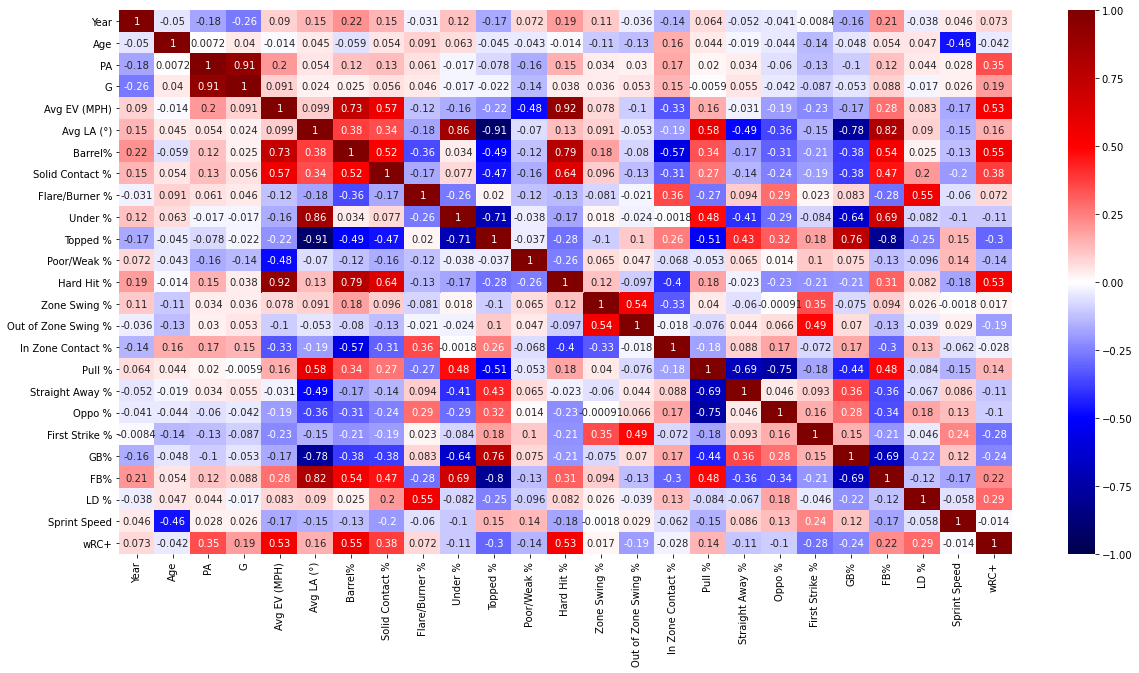

In [12]:
sns.heatmap(stats_2_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

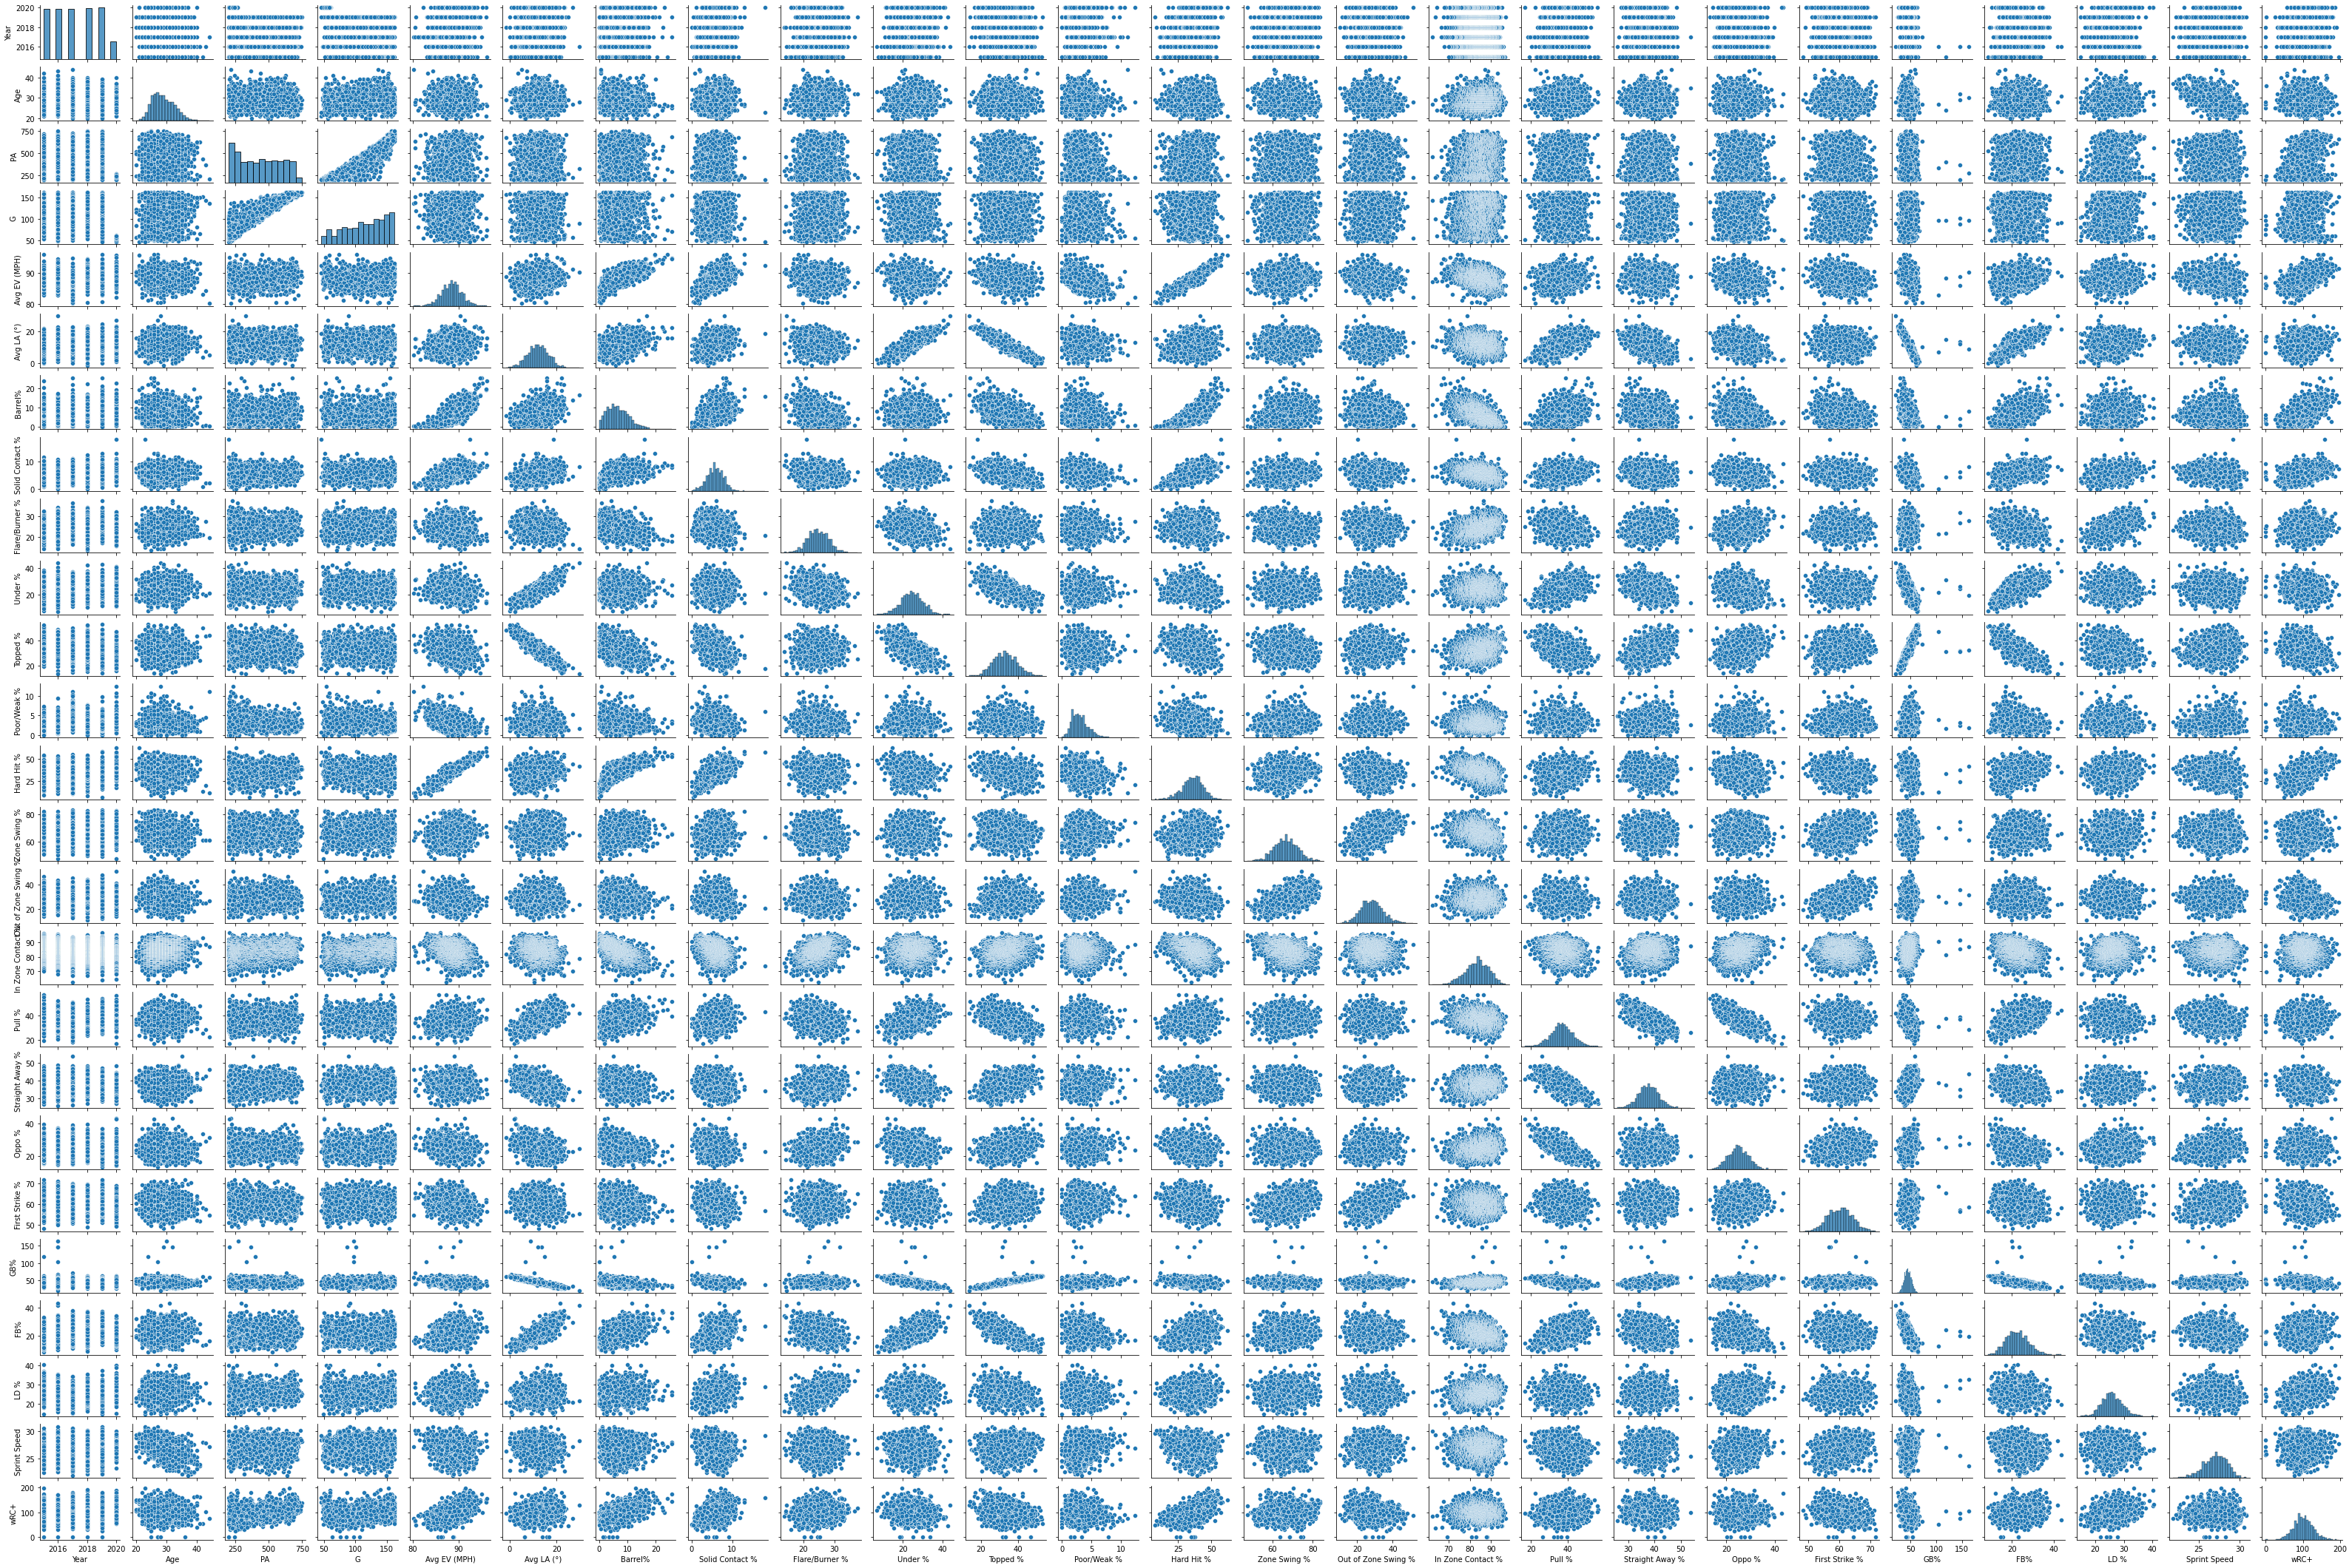

In [13]:
sns.pairplot(stats_2_df, height=1.2, aspect=1.5);

First thing - a few players have GB rate over 100% and In Zone Contact Rate which may be over 100%, which doesn't make sense.  Let's see

Ground Ball Rate:

In [19]:
stats_2_df[stats_2_df['GB%'] > 100]

Empty DataFrame
Columns: [Player, Year, Age, PA, G, Avg EV (MPH), Avg LA (°), Barrel%, Solid Contact %, Flare/Burner %, Under %, Topped %, Poor/Weak %, Hard Hit %, Zone Swing %, Out of Zone Swing %, In Zone Contact %, Pull %, Straight Away %, Oppo %, First Strike %, GB%, FB%, LD %, Sprint Speed, Player Link, Player_Year_ID, wRC+]
Index: []

[0 rows x 28 columns]

These are wrong, but the other batted ball data looks right.  Fixing these:

In [20]:
stats_2_df.iloc[94, 21] = 37.8 #Gillaspie, 2016
stats_2_df.iloc[165, 21] = 55.9 #Burns, 2016
stats_2_df.iloc[470, 21] = 43.1 #Butler, 2016
stats_2_df.iloc[651, 21] = 43.3 #Lowrie, 2016
stats_2_df.iloc[1226, 21] = 41.9 #Suarez, 2015

In [21]:
stats_2_df[stats_2_df['GB%'] > 100]

Empty DataFrame
Columns: [Player, Year, Age, PA, G, Avg EV (MPH), Avg LA (°), Barrel%, Solid Contact %, Flare/Burner %, Under %, Topped %, Poor/Weak %, Hard Hit %, Zone Swing %, Out of Zone Swing %, In Zone Contact %, Pull %, Straight Away %, Oppo %, First Strike %, GB%, FB%, LD %, Sprint Speed, Player Link, Player_Year_ID, wRC+]
Index: []

[0 rows x 28 columns]

In Zone Contact:

In [22]:
stats_2_df[stats_2_df['In Zone Contact %'] > 100]

Empty DataFrame
Columns: [Player, Year, Age, PA, G, Avg EV (MPH), Avg LA (°), Barrel%, Solid Contact %, Flare/Burner %, Under %, Topped %, Poor/Weak %, Hard Hit %, Zone Swing %, Out of Zone Swing %, In Zone Contact %, Pull %, Straight Away %, Oppo %, First Strike %, GB%, FB%, LD %, Sprint Speed, Player Link, Player_Year_ID, wRC+]
Index: []

[0 rows x 28 columns]

In [37]:
stats_2_df[stats_2_df['wRC+'].isnull()].sort_values(by='Year')

Player    Year   Age     PA      G  Avg EV (MPH)  Avg LA (°)  \
132   Ramirez, Jose  2015.0  23.0  355.0   97.0          86.6        12.0   
230   Ramirez, Jose  2016.0  24.0  618.0  152.0          88.4        13.2   
181   Ramirez, Jose  2017.0  25.0  645.0  152.0          88.2        15.0   
225   Ramirez, Jose  2018.0  26.0  698.0  157.0          89.0        19.0   
137   Ramirez, Jose  2019.0  27.0  542.0  129.0          89.2        19.8   
525   Ramirez, Jose  2020.0  28.0  254.0   58.0          88.7        23.2   

     Barrel%  Solid Contact %  Flare/Burner %  ...  Straight Away %  Oppo %  \
132      1.8              2.8            23.0  ...             35.0    24.7   
230      3.0              5.5            27.8  ...             36.2    28.1   
181      5.0              7.1            27.8  ...             34.9    22.3   
225      8.3              7.9            19.8  ...             33.9    18.3   
137      6.3              7.0            25.1  ...             31.2    20.8   
525     10.2              6.2            21.5  ...             33.9    18.6   

     First Strike %   GB%   FB%  LD %  Sprint Speed              Player Link  \
132            58.0  49.8  23.3  19.8          28.0  [/savant-player/608070]   
230            57.0  41.5  20.1  31.7          27.9  [/savant-player/608070]   
181            56.0  40.3  24.4  27.6          28.0  [/savant-player/608070]   
225            53.0  33.9  31.2  23.4          27.5  [/savant-player/608070]   
137            56.8  33.8  29.7  25.6          27.8  [/savant-player/608070]   
525            52.4  29.9  26.0  28.2          27.2  [/savant-player/608070]   

        Player_Year_ID  wRC+  
132  Jose Ramirez-2015   NaN  
230  Jose Ramirez-2016   NaN  
181  Jose Ramirez-2017   NaN  
225  Jose Ramirez-2018   NaN  
137  Jose Ramirez-2019   NaN  
525  Jose Ramirez-2020   NaN  

[6 rows x 28 columns]

In [38]:
stats_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   float64
 10  Under %              1893 non-null   float64
 11  Topped %             1893 non-null   float64
 12  Poor/Weak %          1893 non-null   float64
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

In [39]:
stats_2_df.iloc[225, 27] = 146 #2018
stats_2_df.iloc[137, 27] = 104 #2019
stats_2_df.iloc[525, 27] = 163 #2020
stats_2_df.iloc[181, 27] = 146 #2017
stats_2_df.iloc[132, 27] = 72 #2015
stats_2_df.iloc[230, 27] = 119 #2016

In [40]:
stats_2_df[stats_2_df['wRC+'].isnull()].sort_values(by='Year')

Empty DataFrame
Columns: [Player, Year, Age, PA, G, Avg EV (MPH), Avg LA (°), Barrel%, Solid Contact %, Flare/Burner %, Under %, Topped %, Poor/Weak %, Hard Hit %, Zone Swing %, Out of Zone Swing %, In Zone Contact %, Pull %, Straight Away %, Oppo %, First Strike %, GB%, FB%, LD %, Sprint Speed, Player Link, Player_Year_ID, wRC+]
Index: []

[0 rows x 28 columns]

In [43]:
stats_2_df.to_pickle("./new_stats.pkl")

### NEXT: new_stats_modeling.ipynb